In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [282]:
all_pitches = pd.read_csv('2024_Complete_TrackMan_Data.csv')
all_pitches = all_pitches[['Date', 'Pitcher', 'PitcherTeam', 'PitcherThrows', 'TaggedPitchType', 'PitchCall', 'PlayResult', 'RelSpeed', 'PlateLocHeight', 'PlateLocSide', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle', 'Level', 'PitchReleaseConfidence', 'PitchLocationConfidence', 'PitchMovementConfidence']]

C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\3657786436.py:1: DtypeWarning: Columns (29,94,95,96) have mixed types. Specify dtype option on import or set low_memory=False.
  all_pitches = pd.read_csv('2024_Complete_TrackMan_Data.csv')


In [283]:
# Select D1 pitches with high confidence levels to eliminate misreads
all_pitches = all_pitches[(all_pitches['Level'] == 'D1') & (all_pitches['PitchReleaseConfidence'] == 'High') & (all_pitches['PitchLocationConfidence'] == 'High') & (all_pitches['PitchMovementConfidence'] == 'High')].drop(columns = ['Level', 'PitchReleaseConfidence', 'PitchLocationConfidence', 'PitchMovementConfidence'])
# Take out pitches with unknown pitch types
all_pitches = all_pitches[(all_pitches['TaggedPitchType'] != 'Other') & (all_pitches['TaggedPitchType'] != 'Undefined')].reset_index()
# Get common names for FF and FS
all_pitches['TaggedPitchType'] = all_pitches['TaggedPitchType'].replace({
    'FourSeamFastBall': 'Fastball',
    'TwoSeamFastBall': 'Sinker'
})
all_pitches

,index,Date,Pitcher,PitcherTeam,PitcherThrows,TaggedPitchType,PitchCall,PlayResult,RelSpeed,PlateLocHeight,PlateLocSide,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle
0,0,2024-02-16,"Scavone, Tommy",PEP_WAV,Right,Fastball,InPlay,Out,92.46566,2.30371,-0.09952,6.13502,1.45834,6.56930,18.21572,12.71343,-5.595635,-0.544808
1,1,2024-02-16,"Scavone, Tommy",PEP_WAV,Right,Fastball,BallCalled,Undefined,94.01239,2.20297,1.03802,6.17463,1.25285,6.63680,21.27690,10.33087,-5.367363,0.705133
2,2,2024-02-16,"Scavone, Tommy",PEP_WAV,Right,Fastball,BallCalled,Undefined,93.53813,1.84496,-2.62468,6.14964,1.27202,6.64242,21.71631,9.66796,-5.726439,-3.375209
3,3,2024-02-16,"Scavone, Tommy",PEP_WAV,Right,Fastball,StrikeCalled,Undefined,93.45011,2.69952,-0.96273,6.18241,1.33551,6.46509,21.84749,11.51552,-4.822360,-1.459286
4,4,2024-02-16,"Scavone, Tommy",PEP_WAV,Right,Fastball,BallCalled,Undefined,93.07141,1.31319,0.73596,6.19217,1.18000,6.64494,22.33170,8.27477,-6.291181,0.267565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419471,1677562,2024-06-24,"Combs, Aaron",TEN_VOL,Right,Fastball,StrikeSwinging,Undefined,92.18631,3.18957,0.77831,4.79234,1.48251,5.16822,12.64422,18.25938,-3.753137,0.867156
1419472,1677563,2024-06-24,"Combs, Aaron",TEN_VOL,Right,Fastball,StrikeCalled,Undefined,92.64280,3.09837,-0.84427,4.86392,1.38315,5.05159,15.40280,13.05642,-3.653929,-1.209960
1419473,1677564,2024-06-24,"Combs, Aaron",TEN_VOL,Right,Fastball,StrikeSwinging,Undefined,93.60782,3.60768,-0.76626,5.06982,1.12860,5.29399,17.26068,10.25316,-3.090463,-1.109277
1419474,1677565,2024-06-24,"Combs, Aaron",TEN_VOL,Right,Fastball,BallCalled,Undefined,92.70635,4.86704,-1.41462,4.83466,1.39461,5.42663,16.00694,10.33784,-1.669483,-2.081033


## EDA and Feature Engineering

The framework for my Stuff+ model and the features I will choose and engineer comes from Driveline's latest update on their Stuff+ model, and the article linked below written by Jack Lambert.

https://www.drivelinebaseball.com/2024/05/revisiting-stuff-plus/?srsltid=AfmBOopGkhsGZh2yfV9VvogvC-Yw6-_4qBDnrqvPAXIf07Qeqjv-47Xx

Specifically, I will use their methods of adjusting the approach angles and quantifying movement on breaking balls and offspeed pitches by the differences in vertical and horizontal break from that pitcher's primary fastball.

In [284]:
# explore with subset of data
mess_set = all_pitches[:10000]

The first feature engineering that needs to be done is adjusting the approach angles. As seen in the charts below, Both VAA and HAA are highly correlated to the vertical and horizontal location of the pitch, respectively. Since Stuff+ is a location-independent metric, I want to eliminate effects of pitch location on the pitch result as much as possible. However, apporach angles do factor into a hitter's likelihood to swing and miss at a pitch, and how "nasty" the pitch is, so I want to keep them in the model. To do this, I will create a new metric for each - Adjusted VAA and Adjusted HAA - which normalize the approach angle based on the location of the pitch, and in the case of Adjusted HAA, the handedness of the pitcher.

Articles for both metrics are linked here

[Adjusted VAA](https://blogs.fangraphs.com/a-visualized-primer-on-vertical-approach-angle-vaa/), by Alex Chamberlain

[Adjusted HAA](https://blogs.fangraphs.com/a-visual-primer-on-horizontal-approach-angle-haa/), by Alex Chamberlain

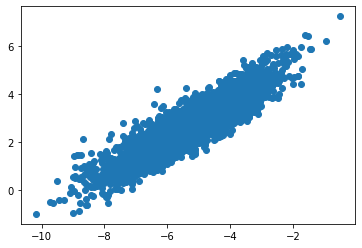

In [285]:
mess_set_FB = mess_set[mess_set['TaggedPitchType'] == 'Fastball']
# Show correlation between pitch height and VAA before normalization
plt.scatter(mess_set_FB['VertApprAngle'], mess_set_FB['PlateLocHeight'])

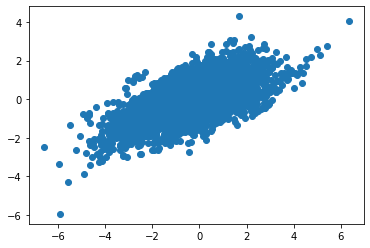

In [286]:
plt.scatter(mess_set_FB['HorzApprAngle'], mess_set_FB['PlateLocSide'])

In [287]:
# Calculate adjusted VAA and adjusted HAA
mess_set_adj = []
for p_type in mess_set['TaggedPitchType'].unique():
    mess_set_pitch = mess_set[mess_set['TaggedPitchType'] == p_type]
    both_hands = []
    # Adjusted HAA - normalize for pitch location and pitcher handedness
    for hand in ['Left', 'Right']:
        mess_set_pitch_hand = mess_set_pitch[mess_set_pitch['PitcherThrows'] == hand]
        mess_set_pitch_hand['side_bin'] = pd.cut(mess_set_pitch_hand['PlateLocSide'], bins=15)

        # Calculate mean HAA for each side bin
        haa_by_side = mess_set_pitch_hand.groupby('side_bin')['HorzApprAngle'].mean().reset_index()

        # Merge this back with the original dataframe
        mess_set_pitch_hand = mess_set_pitch_hand.merge(haa_by_side, on='side_bin', suffixes=('', '_mean'))

        # Calculate HAA Above/Below Average
        mess_set_pitch_hand['AdjustedHAA'] = mess_set_pitch_hand['HorzApprAngle'] - mess_set_pitch_hand['HorzApprAngle_mean']
        
        both_hands.append(mess_set_pitch_hand)
        
    mess_set_pitch = pd.concat(both_hands)
    mess_set_pitch['height_bin'] = pd.cut(mess_set_pitch['PlateLocHeight'], bins=15)

    # Calculate mean VAA for each height bin
    vaa_by_height = mess_set_pitch.groupby('height_bin')['VertApprAngle'].mean().reset_index()

    # Merge this back with the original dataframe
    mess_set_pitch = mess_set_pitch.merge(vaa_by_height, on='height_bin', suffixes=('', '_mean'))

    # Calculate VAA Above/Below Average
    mess_set_pitch['AdjustedVAA'] = mess_set_pitch['VertApprAngle'] - mess_set_pitch['VertApprAngle_mean']
    
    # Will drop PlateLocSide and PlateLocHeight when applied to all_pitches dataframe
    mess_set_new = mess_set_pitch.drop(columns = ['VertApprAngle', 'HorzApprAngle', 'height_bin', 'side_bin', 'VertApprAngle_mean', 'HorzApprAngle_mean'])
    if p_type == 'Fastball':
        mess_set_adj = mess_set_new
    else:
        mess_set_adj = mess_set_adj.append(mess_set_new)

mess_set_adj

C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\1511347417.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess_set_pitch_hand['side_bin'] = pd.cut(mess_set_pitch_hand['PlateLocSide'], bins=15)
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\1511347417.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess_set_pitch_hand['side_bin'] = pd.cut(mess_set_pitch_hand['PlateLocSide'], bins=15)
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\1511347417.py:9: SettingWithC

,index,Date,Pitcher,PitcherTeam,PitcherThrows,TaggedPitchType,PitchCall,PlayResult,RelSpeed,PlateLocHeight,PlateLocSide,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,AdjustedHAA,AdjustedVAA
0,333,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,StrikeCalled,Undefined,89.56139,2.50382,0.41609,5.99563,-2.62557,5.92561,15.26347,-14.75560,0.771710,-0.352832
1,337,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,StrikeCalled,Undefined,88.73077,2.80538,0.02230,5.77085,-3.17374,6.21944,8.58748,-16.77414,0.767888,-0.454553
2,351,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,FoulBall,Undefined,89.71028,2.55383,0.39137,5.95561,-2.99964,6.17858,16.01985,-14.87418,1.148881,-0.211942
3,354,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,InPlay,Out,90.05652,2.61858,0.26261,5.95849,-3.04142,6.10764,15.32946,-11.85524,1.321952,-0.248385
4,458,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,StrikeSwinging,Undefined,89.69116,2.55130,-0.01259,5.96190,-3.11298,6.06580,21.10340,-11.99764,1.088306,0.218124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,10935,2024-02-16,"Freeman, Kamu",CAM_CAM,Right,Sinker,BallCalled,Undefined,85.31311,4.65344,-0.23534,6.23593,1.30265,6.01529,11.04753,10.81819,0.100251,-0.604838
298,3391,2024-02-16,"Yeager, Isaac",WAS_HUS,Right,Sinker,BallCalled,Undefined,90.85933,4.59836,1.01781,6.03487,1.67413,6.19560,12.41178,18.87021,0.777054,0.065420
299,5712,2024-02-16,"Ray, William",WAK_DEA,Right,Sinker,BallCalled,Undefined,89.52002,4.33128,1.47991,4.58005,2.69431,6.17204,4.06811,22.31356,-0.283225,0.539417
300,3115,2024-02-16,"Hood, CJ",LON_DIR,Right,Sinker,BallCalled,Undefined,91.99615,4.92723,2.31247,5.97962,1.96347,5.35964,15.04564,16.87091,-0.060266,-0.246269


Now to visualize the results. Both charts below show no correlation between the adjusted VAA and adjusted HAA and the vertical and horizonal location of the pitch, respectively. This metric can now be used as a feature in the Stuff+ model that captures the location-independent affect of approach angles. 

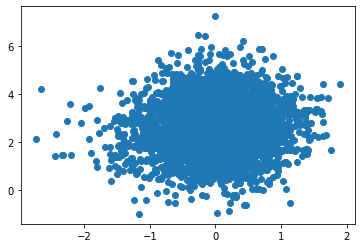

In [288]:
viz_adj = mess_set_adj[mess_set_adj['TaggedPitchType'] == 'Fastball']
plt.scatter(viz_adj['AdjustedVAA'], viz_adj['PlateLocHeight'])

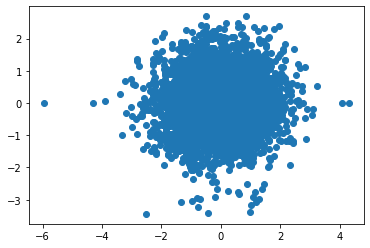

In [289]:
viz_adj = mess_set_adj[mess_set_adj['TaggedPitchType'] == 'Fastball']
plt.scatter(viz_adj['PlateLocSide'], viz_adj['AdjustedHAA'])

Next, I want to look at whether there is any correlation between the new Adjusted VAA and Adjusted HAA metrics and the release point of the pitch.

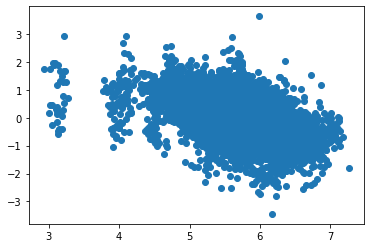

In [290]:
plt.scatter(mess_set_adj['RelHeight'], mess_set_adj['AdjustedVAA'])

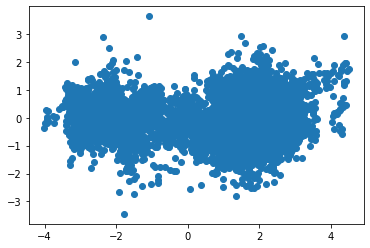

In [291]:
plt.scatter(mess_set_adj['RelSide'], mess_set_adj['AdjustedVAA'])

The first chart, showing the relationship between release height and adjusted VAA shows some negative correlation between the two, but not a lot. All it shows is that once release height exceeds 6ft, it becomes difficult to achieve a flat VAA, but there is enough variation among release heights under 6ft to make it worth keeping it in my model. The second chart, showing the relationship between release side and adjusted HAA shows no correlation between the two. As a result, I will keep both release point metrics in my model as features.

The next step in feature engineering is calculating the difference in movement profiles between each pitcher's primary fastball and their offspeeds. I believe this is a truer reflection of how nasty an offspeed pitch is over its raw movement profile because hitters can and will adjust to the shape of a pitcher's fastball, so differing movement from the fastball will cause whiffs. For instance, two pitchers throw a changeup with 7 IVB and 19 HB, but one has a fastball with 21 IVB and 8 HB while the other has a sinker with 8 IVB and 18 HB, the changeup should not be graded the same. The second pitcher's changeup is nearly identical to his primary fastball, while the first pitcher generates a huge movement difference. Furthermore, the difference in break should help the model more accurately find the characteristics that cause whiffs. I will also account for a difference in velocity when evaluating breaking balls and offspeeds. Some pitchers effectively rely on velocity differences rather than movement differences when throwing these pitches, so I want to capture it in the model.

In [292]:
# Standardize HB to be the same sign for LHP and RHP
mess_set_adj['StandardizedHB'] = mess_set_adj.apply(lambda row: -row['HorzBreak'] if row['PitcherThrows'] == 'Left' else row['HorzBreak'], axis=1)
mess_set_adj

,index,Date,Pitcher,PitcherTeam,PitcherThrows,TaggedPitchType,PitchCall,PlayResult,RelSpeed,PlateLocHeight,PlateLocSide,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,AdjustedHAA,AdjustedVAA,StandardizedHB
0,333,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,StrikeCalled,Undefined,89.56139,2.50382,0.41609,5.99563,-2.62557,5.92561,15.26347,-14.75560,0.771710,-0.352832,14.75560
1,337,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,StrikeCalled,Undefined,88.73077,2.80538,0.02230,5.77085,-3.17374,6.21944,8.58748,-16.77414,0.767888,-0.454553,16.77414
2,351,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,FoulBall,Undefined,89.71028,2.55383,0.39137,5.95561,-2.99964,6.17858,16.01985,-14.87418,1.148881,-0.211942,14.87418
3,354,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,InPlay,Out,90.05652,2.61858,0.26261,5.95849,-3.04142,6.10764,15.32946,-11.85524,1.321952,-0.248385,11.85524
4,458,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,StrikeSwinging,Undefined,89.69116,2.55130,-0.01259,5.96190,-3.11298,6.06580,21.10340,-11.99764,1.088306,0.218124,11.99764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,10935,2024-02-16,"Freeman, Kamu",CAM_CAM,Right,Sinker,BallCalled,Undefined,85.31311,4.65344,-0.23534,6.23593,1.30265,6.01529,11.04753,10.81819,0.100251,-0.604838,10.81819
298,3391,2024-02-16,"Yeager, Isaac",WAS_HUS,Right,Sinker,BallCalled,Undefined,90.85933,4.59836,1.01781,6.03487,1.67413,6.19560,12.41178,18.87021,0.777054,0.065420,18.87021
299,5712,2024-02-16,"Ray, William",WAK_DEA,Right,Sinker,BallCalled,Undefined,89.52002,4.33128,1.47991,4.58005,2.69431,6.17204,4.06811,22.31356,-0.283225,0.539417,22.31356
300,3115,2024-02-16,"Hood, CJ",LON_DIR,Right,Sinker,BallCalled,Undefined,91.99615,4.92723,2.31247,5.97962,1.96347,5.35964,15.04564,16.87091,-0.060266,-0.246269,16.87091


In [293]:
# Find the fastball each pitcher threw the most frequently (FF, FS, FC)
gb_pitcher = mess_set_adj[(mess_set_adj['TaggedPitchType'] == 'Fastball') | (mess_set_adj['TaggedPitchType'] == 'Sinker') | (mess_set_adj['TaggedPitchType'] == 'Cutter')].groupby(['Pitcher', 'TaggedPitchType']).count()
pitcher_primary_FB = gb_pitcher.groupby(level = 'Pitcher')['Date'].idxmax().apply(lambda x: x[1])
pitcher_primary_FB

Pitcher
Ager, Matt           Fastball
Aiello, Christian    Fastball
Allen, Colby         Fastball
Alloway, Gavin       Fastball
Amborn, Cal          Fastball
                       ...   
Yawn, Garrett        Fastball
Yeager, Isaac          Sinker
Yesavage, Trey       Fastball
Yetter, Brian        Fastball
Young, Brian         Fastball
Name: Date, Length: 247, dtype: object

In [294]:
# Calculate average shape of pitcher's primary fastball
mess_set_adj['primaryFB'] = mess_set_adj['Pitcher'].map(pitcher_primary_FB)
pitcher_FB_shape = mess_set_adj[mess_set_adj['TaggedPitchType'] == mess_set_adj['primaryFB']].groupby('Pitcher')[['RelSpeed','InducedVertBreak', 'StandardizedHB']].mean()
mess_set_adj_shapes = mess_set_adj.merge(pitcher_FB_shape, on='Pitcher', suffixes=('', 'FBavg'))
mess_set_adj_shapes

,index,Date,Pitcher,PitcherTeam,PitcherThrows,TaggedPitchType,PitchCall,PlayResult,RelSpeed,PlateLocHeight,...,Extension,InducedVertBreak,HorzBreak,AdjustedHAA,AdjustedVAA,StandardizedHB,primaryFB,RelSpeedFBavg,InducedVertBreakFBavg,StandardizedHBFBavg
0,333,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,StrikeCalled,Undefined,89.56139,2.50382,...,5.92561,15.26347,-14.75560,0.771710,-0.352832,14.75560,Fastball,89.232838,12.707468,15.241801
1,337,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,StrikeCalled,Undefined,88.73077,2.80538,...,6.21944,8.58748,-16.77414,0.767888,-0.454553,16.77414,Fastball,89.232838,12.707468,15.241801
2,351,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,FoulBall,Undefined,89.71028,2.55383,...,6.17858,16.01985,-14.87418,1.148881,-0.211942,14.87418,Fastball,89.232838,12.707468,15.241801
3,354,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,InPlay,Out,90.05652,2.61858,...,6.10764,15.32946,-11.85524,1.321952,-0.248385,11.85524,Fastball,89.232838,12.707468,15.241801
4,458,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,StrikeSwinging,Undefined,89.69116,2.55130,...,6.06580,21.10340,-11.99764,1.088306,0.218124,11.99764,Fastball,89.232838,12.707468,15.241801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2533,2024-02-16,"Kleinfelter, Matthew",JMU_DUK,Right,Cutter,StrikeCalled,Undefined,81.73820,1.53740,...,5.26035,9.36788,0.13472,-2.471004,1.530497,0.13472,Cutter,81.906520,7.508612,-0.608899
9996,2529,2024-02-16,"Kleinfelter, Matthew",JMU_DUK,Right,Cutter,BallCalled,Undefined,83.00333,3.26504,...,5.53231,7.17461,0.29909,-2.199729,1.305488,0.29909,Cutter,81.906520,7.508612,-0.608899
9997,2530,2024-02-16,"Kleinfelter, Matthew",JMU_DUK,Right,Cutter,StrikeCalled,Undefined,84.02201,3.10190,...,5.27573,6.59729,-3.14571,-1.725226,-0.256852,-3.14571,Cutter,81.906520,7.508612,-0.608899
9998,2532,2024-02-16,"Kleinfelter, Matthew",JMU_DUK,Right,Cutter,BallCalled,Undefined,81.30962,1.28216,...,5.40685,6.64804,-0.41508,-1.606043,1.072817,-0.41508,Cutter,81.906520,7.508612,-0.608899


In [298]:
# Slice dataframe in two - one for fastballs (all FF, FS, FC will be standalone, not dependent on primary FB shape) - one for 
# offspeed (use avg columns to do array subtraction)
mess_adj_shape_FB = mess_set_adj_shapes[(mess_set_adj_shapes['TaggedPitchType'] == 'Fastball') | (mess_set_adj_shapes['TaggedPitchType'] == 'Sinker') | ((mess_set_adj_shapes['TaggedPitchType'] == 'Cutter') & (mess_set_adj_shapes['primaryFB'] == 'Cutter'))]
mess_adj_shape_BB = mess_set_adj_shapes[(mess_set_adj_shapes['TaggedPitchType'] == 'Curveball') | (mess_set_adj_shapes['TaggedPitchType'] == 'Slider') | ((mess_set_adj_shapes['TaggedPitchType'] == 'Cutter') & (mess_set_adj_shapes['primaryFB'] != 'Cutter'))]
mess_adj_shape_OS = mess_set_adj_shapes[(mess_set_adj_shapes['TaggedPitchType'] == 'ChangeUp') | (mess_set_adj_shapes['TaggedPitchType'] == 'Splitter') | (mess_set_adj_shapes['TaggedPitchType'] == 'Knuckleball')]

mess_adj_shape_BB['VeloDiff'] = mess_adj_shape_BB['RelSpeed'] - mess_adj_shape_BB['RelSpeedFBavg']
mess_adj_shape_BB['IVBDiff'] = mess_adj_shape_BB['InducedVertBreak'] - mess_adj_shape_BB['InducedVertBreakFBavg']
mess_adj_shape_BB['HBDiff'] = mess_adj_shape_BB['StandardizedHB'] - mess_adj_shape_BB['StandardizedHBFBavg']

mess_adj_shape_OS['VeloDiff'] = mess_adj_shape_OS['RelSpeed'] - mess_adj_shape_OS['RelSpeedFBavg']
mess_adj_shape_OS['IVBDiff'] = mess_adj_shape_OS['InducedVertBreak'] - mess_adj_shape_OS['InducedVertBreakFBavg']
mess_adj_shape_OS['HBDiff'] = mess_adj_shape_OS['StandardizedHB'] - mess_adj_shape_OS['StandardizedHBFBavg']

mess_adj_shape_BB

C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\2976215820.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess_adj_shape_BB['VeloDiff'] = mess_adj_shape_BB['RelSpeed'] - mess_adj_shape_BB['RelSpeedFBavg']
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\2976215820.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess_adj_shape_BB['IVBDiff'] = mess_adj_shape_BB['InducedVertBreak'] - mess_adj_shape_BB['InducedVertBreakFBavg']
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipyker

,index,Date,Pitcher,PitcherTeam,PitcherThrows,TaggedPitchType,PitchCall,PlayResult,RelSpeed,PlateLocHeight,...,AdjustedHAA,AdjustedVAA,StandardizedHB,primaryFB,RelSpeedFBavg,InducedVertBreakFBavg,StandardizedHBFBavg,VeloDiff,IVBDiff,HBDiff
55,405,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Curveball,BallCalled,Undefined,76.20326,0.75848,...,0.212550,0.046978,-4.31610,Fastball,89.232838,12.707468,15.241801,-13.029578,-20.264558,-19.557901
56,334,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Slider,FoulBall,Undefined,77.33869,2.49283,...,0.926026,-1.127232,-7.09296,Fastball,89.232838,12.707468,15.241801,-11.894148,-18.406248,-22.334761
57,342,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Slider,FoulBall,Undefined,75.62675,2.94672,...,1.192919,-0.726199,-8.80158,Fastball,89.232838,12.707468,15.241801,-13.606088,-15.804518,-24.043381
58,440,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Slider,FoulBall,Undefined,76.64753,2.39937,...,0.973813,-1.284005,-11.75705,Fastball,89.232838,12.707468,15.241801,-12.585308,-17.381208,-26.998851
59,336,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Slider,InPlay,Single,77.75408,1.91605,...,0.648719,-1.033744,-7.85355,Fastball,89.232838,12.707468,15.241801,-11.478758,-16.828648,-23.095351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9967,5707,2024-02-16,"Ray, William",WAK_DEA,Right,Slider,InPlay,Out,79.58015,1.57233,...,-1.278562,1.112209,-12.34969,Sinker,89.084985,3.073242,20.694207,-9.504835,-6.317652,-33.043897
9968,5717,2024-02-16,"Ray, William",WAK_DEA,Right,Slider,InPlay,Double,80.01195,1.39424,...,-1.015990,0.949030,-10.39642,Sinker,89.084985,3.073242,20.694207,-9.073035,-5.002772,-31.090627
9979,10983,2024-02-16,"Troye, Ryan",SAN_GAU,Right,Slider,StrikeCalled,Undefined,82.66973,2.49908,...,0.612564,0.620603,-2.05453,Sinker,89.952319,5.603991,20.149387,-7.282589,-0.901191,-22.203917
9980,10980,2024-02-16,"Troye, Ryan",SAN_GAU,Right,Slider,BallCalled,Undefined,81.62017,1.77058,...,1.015865,0.259101,-3.01425,Sinker,89.952319,5.603991,20.149387,-8.332149,-5.099541,-23.163638


In [300]:
# apply changes from mess set to full data
def calc_adj_vaa_haa(pitches):
    pitches_adj = []
    for p_type in pitches['TaggedPitchType'].unique():
        pitches_pitch = pitches[pitches['TaggedPitchType'] == p_type]
        both_hands = []
        # Adjusted HAA - normalize for pitch location and pitcher handedness
        for hand in ['Left', 'Right']:
            pitches_pitch_hand = pitches_pitch[pitches_pitch['PitcherThrows'] == hand]
            pitches_pitch_hand['side_bin'] = pd.cut(pitches_pitch_hand['PlateLocSide'], bins=15)

            # Calculate mean HAA for each side bin
            haa_by_side = pitches_pitch_hand.groupby('side_bin')['HorzApprAngle'].mean().reset_index()

            # Merge this back with the original dataframe
            pitches_pitch_hand = pitches_pitch_hand.merge(haa_by_side, on='side_bin', suffixes=('', '_mean'))

            # Calculate HAA Above/Below Average
            pitches_pitch_hand['AdjustedHAA'] = pitches_pitch_hand['HorzApprAngle'] - pitches_pitch_hand['HorzApprAngle_mean']

            both_hands.append(pitches_pitch_hand)

        pitches_pitch = pd.concat(both_hands)
        pitches_pitch['height_bin'] = pd.cut(pitches_pitch['PlateLocHeight'], bins=15)

        # Calculate mean VAA for each height bin
        vaa_by_height = pitches_pitch.groupby('height_bin')['VertApprAngle'].mean().reset_index()

        # Merge this back with the original dataframe
        pitches_pitch = pitches_pitch.merge(vaa_by_height, on='height_bin', suffixes=('', '_mean'))

        # Calculate VAA Above/Below Average
        pitches_pitch['AdjustedVAA'] = pitches_pitch['VertApprAngle'] - pitches_pitch['VertApprAngle_mean']

        # Will drop PlateLocSide and PlateLocHeight when applied to all_pitches dataframe
        pitches_new = pitches_pitch.drop(columns = ['VertApprAngle', 'HorzApprAngle', 'PlateLocHeight', 'PlateLocSide', 'height_bin', 'side_bin', 'VertApprAngle_mean', 'HorzApprAngle_mean'])
        if p_type == 'Fastball':
            pitches_adj = pitches_new
        else:
            pitches_adj = pitches_adj.append(pitches_new)
    return pitches_adj
    
all_pitches = calc_adj_vaa_haa(all_pitches)

all_pitches['StandardizedHB'] = all_pitches.apply(lambda row: -row['HorzBreak'] if row['PitcherThrows'] == 'Left' else row['HorzBreak'], axis=1)

def get_pitcher_primary_FB_info(pitches):
    gb_pitcher = pitches[(pitches['TaggedPitchType'] == 'Fastball') | (pitches['TaggedPitchType'] == 'Sinker') | (pitches['TaggedPitchType'] == 'Cutter')].groupby(['Pitcher', 'TaggedPitchType']).count()
    pitcher_primary_FB = gb_pitcher.groupby(level = 'Pitcher')['Date'].idxmax().apply(lambda x: x[1])
    pitches['primaryFB'] = pitches['Pitcher'].map(pitcher_primary_FB)
    pitcher_FB_shape = pitches[pitches['TaggedPitchType'] == pitches['primaryFB']].groupby('Pitcher')[['RelSpeed','InducedVertBreak', 'StandardizedHB']].mean()
    pitches_shapes = pitches.merge(pitcher_FB_shape, on='Pitcher', suffixes=('', 'FBavg'))
    return pitches_shapes

all_pitches = get_pitcher_primary_FB_info(all_pitches)

all_pitches_FB = all_pitches[(all_pitches['TaggedPitchType'] == 'Fastball') | (all_pitches['TaggedPitchType'] == 'Sinker') | (all_pitches['TaggedPitchType'] == 'Cutter')]
all_pitches_BB = all_pitches[(all_pitches['TaggedPitchType'] == 'Curveball') | (all_pitches['TaggedPitchType'] == 'Slider')]
all_pitches_OS = all_pitches[(all_pitches['TaggedPitchType'] == 'ChangeUp') | (all_pitches['TaggedPitchType'] == 'Splitter') | (all_pitches['TaggedPitchType'] == 'Knuckleball')]

all_pitches_BB['VeloDiff'] = all_pitches_BB['RelSpeed'] - all_pitches_BB['RelSpeedFBavg']
all_pitches_BB['IVBDiff'] = all_pitches_BB['InducedVertBreak'] - all_pitches_BB['InducedVertBreakFBavg']
all_pitches_BB['HBDiff'] = all_pitches_BB['StandardizedHB'] - all_pitches_BB['StandardizedHBFBavg']

all_pitches_OS['VeloDiff'] = all_pitches_OS['RelSpeed'] - all_pitches_OS['RelSpeedFBavg']
all_pitches_OS['IVBDiff'] = all_pitches_OS['InducedVertBreak'] - all_pitches_OS['InducedVertBreakFBavg']
all_pitches_OS['HBDiff'] = all_pitches_OS['StandardizedHB'] - all_pitches_OS['StandardizedHBFBavg']

all_pitches

C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\480575361.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches_pitch_hand['side_bin'] = pd.cut(pitches_pitch_hand['PlateLocSide'], bins=15)
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\480575361.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches_pitch_hand['side_bin'] = pd.cut(pitches_pitch_hand['PlateLocSide'], bins=15)
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\480575361.py:10: SettingWithCopyW

C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\480575361.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pitches_adj = pitches_adj.append(pitches_new)
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\480575361.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pitches_pitch_hand['side_bin'] = pd.cut(pitches_pitch_hand['PlateLocSide'], bins=15)
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\480575361.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

,index,Date,Pitcher,PitcherTeam,PitcherThrows,TaggedPitchType,PitchCall,PlayResult,RelSpeed,RelHeight,...,Extension,InducedVertBreak,HorzBreak,AdjustedHAA,AdjustedVAA,StandardizedHB,primaryFB,RelSpeedFBavg,InducedVertBreakFBavg,StandardizedHBFBavg
0,333,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,StrikeCalled,Undefined,89.56139,5.99563,...,5.92561,15.26347,-14.75560,0.420057,-0.481919,14.75560,Sinker,88.436251,10.740111,14.436070
1,348,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,StrikeCalled,Undefined,90.32156,6.04119,...,5.98082,20.67336,-12.93493,1.230381,0.415710,12.93493,Sinker,88.436251,10.740111,14.436070
2,351,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,FoulBall,Undefined,89.71028,5.95561,...,6.17858,16.01985,-14.87418,0.797228,-0.341029,14.87418,Sinker,88.436251,10.740111,14.436070
3,354,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,InPlay,Out,90.05652,5.95849,...,6.10764,15.32946,-11.85524,0.970299,-0.377472,11.85524,Sinker,88.436251,10.740111,14.436070
4,450,2024-02-16,"Van Sickle, Bryson",UTA_UTE,Left,Fastball,FoulBall,Undefined,89.41015,5.96576,...,6.19260,19.38603,-10.39567,1.315311,0.194875,10.39567,Sinker,88.436251,10.740111,14.436070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419037,1575219,2024-05-17,"Saum, Charlie",STA_CAR,Right,Sinker,BallCalled,Undefined,88.16958,4.23632,...,5.98090,9.47256,14.98253,-1.270255,1.111131,14.98253,Sinker,90.200053,10.748878,12.332095
1419038,1575221,2024-05-17,"Saum, Charlie",STA_CAR,Right,Sinker,BallCalled,Undefined,89.14888,3.81466,...,5.93455,6.19111,8.59071,-2.548950,1.316015,8.59071,Sinker,90.200053,10.748878,12.332095
1419039,1575218,2024-05-17,"Saum, Charlie",STA_CAR,Right,Sinker,StrikeCalled,Undefined,89.91485,4.89437,...,6.27898,11.05162,12.21430,-1.525238,0.746827,12.21430,Sinker,90.200053,10.748878,12.332095
1419040,1575217,2024-05-17,"Saum, Charlie",STA_CAR,Right,Sinker,BallCalled,Undefined,91.82142,4.81593,...,5.98977,12.87985,13.77115,-1.269304,1.453497,13.77115,Sinker,90.200053,10.748878,12.332095


The features I will use for my model are: RelSpeed, RelHeight, RelSide, Extension, InducedVertBreak, HorzBreak, AdjustedVAA, AdjustedHAA, VeloDiff, IVBDiff, HBDiff (last 3 won't be included in the Fastball model, obviously)

# Initial Model: Logistic Regression

Logistic Regression is not the best method to use for this project but it is something I want to try and it makes sense given the data I have and the outcome I desire. I am basing this Stuff+ model off expected whiff rate (xWhiff). I chose this because I see Stuff+ as the metric that describes how "nasty" a pitch is, and I believe the biggest indicator of nastiness is how often hitters swing and miss. In this case, I will use all of the swings as my training data and the takes as validation/test sets. Each swing either resulted in contact (foul, in play) or a whiff (swinging strike). Since the response (dependent) variable is a binary outcome, and the result I want is some sort of whiff rate or whiff score (between 0 and 1) that determines how that pitch is to produce a whiff, logistic regression makes perfect sense. While it will not do well capturing the intricacies of the data, it gives me a good baseline and a starting point to learn more about the data before choosing another ML algorithm.

In [192]:
swings = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'FoulBall') | (all_pitches_FB['PitchCall'] == 'InPlay') | (all_pitches_FB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()
swings

,PitchCall,RelSpeed,RelHeight,RelSide,Extension,InducedVertBreak,StandardizedHB,AdjustedVAA,AdjustedHAA
2,FoulBall,89.71028,5.95561,-2.99964,6.17858,16.01985,14.87418,-0.341029,0.797228
3,InPlay,90.05652,5.95849,-3.04142,6.10764,15.32946,11.85524,-0.377472,0.970299
4,FoulBall,89.41015,5.96576,-3.06139,6.19260,19.38603,10.39567,0.194875,1.315311
5,InPlay,90.24481,5.87326,-2.65334,6.33172,14.37851,11.22784,-0.363926,0.727228
8,InPlay,89.48053,5.83095,-2.85241,6.23223,13.07816,6.49304,-0.339279,1.317173
...,...,...,...,...,...,...,...,...,...
1419021,StrikeSwinging,90.02041,5.65423,2.00324,6.32573,6.48788,17.78989,-0.674362,0.204965
1419024,StrikeSwinging,91.50278,5.67172,1.97533,6.05734,0.60661,18.27359,-0.705942,0.107341
1419025,StrikeSwinging,91.50278,5.67172,1.97533,6.05734,0.60661,18.27359,-0.705942,0.107341
1419036,StrikeSwinging,90.47699,4.81063,3.26952,5.86821,12.44698,13.34765,1.326349,-1.879976


In [193]:
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)
swings

,PitchCall,RelSpeed,RelHeight,RelSide,Extension,InducedVertBreak,StandardizedHB,AdjustedVAA,AdjustedHAA
2,0,89.71028,5.95561,-2.99964,6.17858,16.01985,14.87418,-0.341029,0.797228
3,0,90.05652,5.95849,-3.04142,6.10764,15.32946,11.85524,-0.377472,0.970299
4,0,89.41015,5.96576,-3.06139,6.19260,19.38603,10.39567,0.194875,1.315311
5,0,90.24481,5.87326,-2.65334,6.33172,14.37851,11.22784,-0.363926,0.727228
8,0,89.48053,5.83095,-2.85241,6.23223,13.07816,6.49304,-0.339279,1.317173
...,...,...,...,...,...,...,...,...,...
1419021,1,90.02041,5.65423,2.00324,6.32573,6.48788,17.78989,-0.674362,0.204965
1419024,1,91.50278,5.67172,1.97533,6.05734,0.60661,18.27359,-0.705942,0.107341
1419025,1,91.50278,5.67172,1.97533,6.05734,0.60661,18.27359,-0.705942,0.107341
1419036,1,90.47699,4.81063,3.26952,5.86821,12.44698,13.34765,1.326349,-1.879976


In [145]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [189]:
X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

log_reg_model_FB = linear_model.LogisticRegression(max_iter = 1000).fit(X_train, y_train)
results_FB = log_reg_model_FB.predict_proba(X_train)

In [147]:
x_whiff = [x[1] for x in results_FB]
x_whiff

[0.24693539434520037,
 0.39011332158356354,
 0.2974121263186834,
 0.2555154694647339,
 0.3309265513916785,
 0.1878309683190156,
 0.12720021484642396,
 0.3067154421403804,
 0.2930153602968076,
 0.2940193097548648,
 0.23836196217998548,
 0.18366790189078624,
 0.39612579487054506,
 0.24355356304768622,
 0.24853149280850728,
 0.18315245050212414,
 0.13297241194439582,
 0.23521708335022729,
 0.23682606973426837,
 0.2969996687229803,
 0.3480653460373295,
 0.22478588797376017,
 0.29731670179393255,
 0.20131062300871944,
 0.18263875604234545,
 0.3446183479024818,
 0.27295676596960644,
 0.2737901577303087,
 0.3342883326275585,
 0.15859380752912983,
 0.18797572103349877,
 0.2305483703152854,
 0.20030642533198528,
 0.26543653892957747,
 0.274017369579178,
 0.35647049518365703,
 0.3487761268958881,
 0.32412030155279714,
 0.2128798990439846,
 0.28711662255427933,
 0.17024814809405944,
 0.30404175488134155,
 0.2369165743042828,
 0.32815595939017117,
 0.27700818829012785,
 0.21947838648331966,
 0.440

In [148]:
avg_x_whiff_train = np.mean(x_whiff)
avg_x_whiff_train

0.2714509642411203

In [149]:
actual_whiff_pct_train = y_train.mean()
actual_whiff_pct_train

0.2714356561716729

Well that's cool. Model must be doing something right. Lets see if it holds up for test data

In [150]:
results_test_FB = log_reg_model_FB.predict_proba(X_test)
x_whiff_test = [x[1] for x in results_test_FB]
avg_x_whiff_test = np.mean(x_whiff_test)
actual_whiff_pct_test = y_test.mean()
avg_x_whiff_test, actual_whiff_pct_test

(0.2713236018409464, 0.27269802975472457)

Also very close. The model seems to be accurately capturing the frequency of whiffs on fastballs. Now let's use a more robust accuracy metric to determine the strength of the model. I will use Log Loss, or Cross Entropy loss, as it reliably captures loss when the output is a probability and the labels are binary, while taking into account confidence of prediction.

In [151]:
train_log_loss = metrics.log_loss(y_train, x_whiff)
test_log_loss = metrics.log_loss(y_test, x_whiff_test)
train_log_loss, test_log_loss

(0.5711011594923557, 0.573372684525491)

Compare to baseline of predicting no whiff (~73% of fastballs were not whiffed at) for every pitch

In [152]:
no_skill_baseline_logloss_FB = metrics.log_loss(y_test, np.zeros(y_test.shape[0]))
no_skill_baseline_logloss_FB

9.418656273031132

So yes, the logistic regression model fares better than the trivial model. Now let's visualize the results

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')]

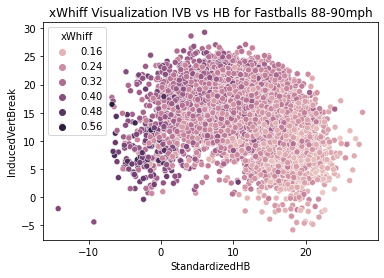

In [153]:
import seaborn as sns

X_test['xWhiff'] = x_whiff_test
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 90-92mph')]

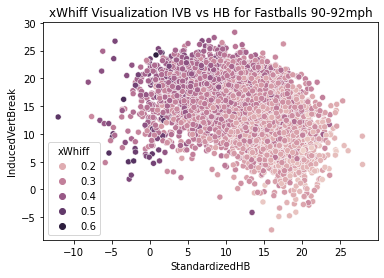

In [154]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 90-92mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')]

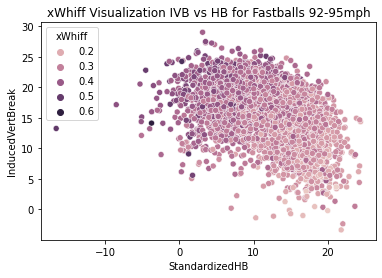

In [155]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs >95mph')]

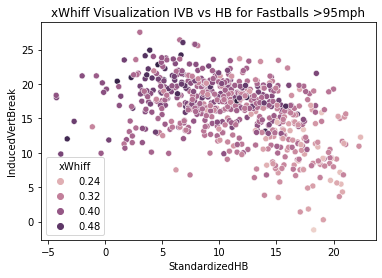

In [156]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 95]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 95]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 95]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs >95mph')

These visualizations don't capture all the features in the model, but they give a good sense of what the model is doing. A few things stand out. First of all, as the velocity increases over the course of the charts, the concentration of darker purple dots, indicating higher xWhiff, increases. This makes sense, as faster fastballs tend to be swung and missed at more and tend to be better pitches. Secondly, the model (as expected) has difficulty capturing finer elements of the data. It favors high IVB fastballs, which also makes sense, but significantly reduces the xWhiff of low very IVB fastballs. Very low IVB fastballs tend to be very good sinkers, which also generate swings and misses. In my first iteration of the model, I used Horizontal Break as a standard feature, which it struggled to capture as a feature. By leaving horizontal break as is, LHP will throw fastballs with negative HB and righties will throw fastballs with positive HB, and naturally so, this does not align with what logistic regression can capture. However, by flipping the sign of LHP HB, the model now seems to favor cutters, with HB close to 0, so perhaps that is the model saying that pitch type is effective.

To generate baselines for the other pitch types, I will create Logistic Regression models for Breaking Balls and Offspeeds just as I did for fastballs

In [191]:
swings = all_pitches_BB[(all_pitches_BB['PitchCall'] == 'FoulBall') | (all_pitches_BB['PitchCall'] == 'InPlay') | (all_pitches_BB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)
swings

,PitchCall,RelSpeed,RelHeight,RelSide,Extension,InducedVertBreak,StandardizedHB,AdjustedVAA,AdjustedHAA,VeloDiff,IVBDiff,HBDiff
277,1,76.40850,5.75778,-2.64605,6.04706,-5.11524,-4.17366,-0.020486,0.740081,-12.027751,-15.855351,-18.609730
281,1,76.40063,5.71513,-2.71669,5.51594,-6.22847,-8.09150,0.651098,1.128215,-12.035621,-16.968581,-22.527570
282,0,75.34583,5.69595,-2.97260,5.63877,-6.96225,-5.86658,0.463729,0.937605,-13.090421,-17.702361,-20.302650
283,1,75.43193,5.73845,-2.86262,5.68104,-4.56709,-0.00453,0.690815,0.550896,-13.004321,-15.307201,-14.440600
285,1,76.08913,5.72215,-2.51439,5.36925,-2.88433,-3.02606,0.934495,0.142394,-12.347121,-13.624441,-17.462130
...,...,...,...,...,...,...,...,...,...,...,...,...
1418844,0,80.09125,2.77692,3.59100,6.93409,-3.06595,14.18863,2.695686,-0.292964,3.279407,-0.492870,-1.577680
1418845,0,68.40445,2.90162,3.72054,6.23089,10.08020,-11.30304,2.123743,-2.667502,-8.407393,12.653280,-27.069350
1418917,1,71.42630,4.84334,3.11885,5.39990,-0.51638,-11.62201,-0.643195,-1.395669,-7.331369,-2.177262,-26.697052
1418918,1,70.97259,4.76992,2.91063,5.55600,-3.58118,-9.71678,-0.225403,-0.926907,-7.785079,-5.242062,-24.791822


In [158]:
X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

log_reg_model_BB = linear_model.LogisticRegression(max_iter = 1000).fit(X_train, y_train)
results_BB = log_reg_model_BB.predict_proba(X_train)
x_whiff_train_BB = [x[1] for x in results_BB]
avg_x_whiff_train_BB = np.mean(x_whiff_train_BB)
actual_whiff_pct_train_BB = y_train.mean()
avg_x_whiff_train_BB, actual_whiff_pct_train_BB

(0.4268578142405502, 0.42686856537622636)

In [159]:
results_test_BB = log_reg_model_BB.predict_proba(X_test)
x_whiff_test_BB = [x[1] for x in results_test_BB]
avg_x_whiff_test_BB = np.mean(x_whiff_test_BB)
actual_whiff_pct_test_BB = y_test.mean()
avg_x_whiff_test_BB, actual_whiff_pct_test_BB

(0.4280943173051787, 0.42749818240568704)

In [160]:
train_log_loss_BB = metrics.log_loss(y_train, x_whiff_train_BB)
test_log_loss_BB = metrics.log_loss(y_test, x_whiff_test_BB)
train_log_loss_BB, test_log_loss_BB

(0.6728053173544506, 0.6698340604573025)

In [161]:
no_skill_baseline_logloss_BB = metrics.log_loss(y_test, np.zeros(y_test.shape[0]))
no_skill_baseline_logloss_BB

14.765264131340764

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls <70mph')]

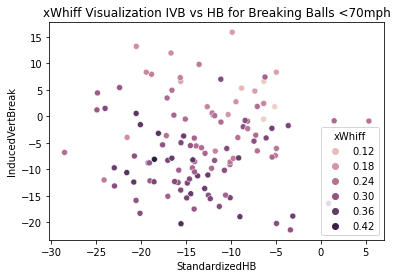

In [162]:
X_test['xWhiff'] = x_whiff_test_BB
sns.scatterplot(x = X_test[(X_test['RelSpeed'] < 70)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] < 70)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] < 70)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls <70mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 70-75mph')]

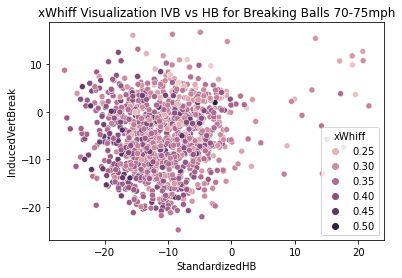

In [163]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 70-75mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 75-80mph')]

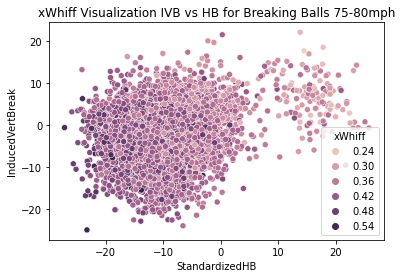

In [164]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 75-80mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 80-85mph')]

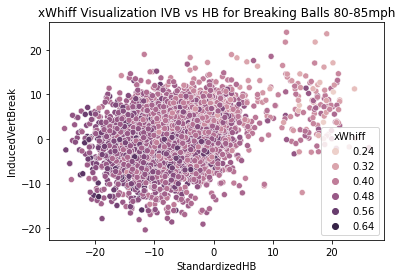

In [165]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 80-85mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls >85mph')]

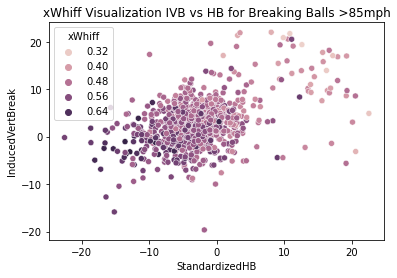

In [166]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 85]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 85]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 85]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls >85mph')

As with the Fastball model, the Breaking Ball model favors harder breaking balls. The maximum xWhiff on the <70 mph legend is 0.42, right around the average for the dataset, while the maximum xWhiff for the 80-85 and 85+ legends are 0.64. Similarly, the model favors negative IVB and more glove side HB, although it seems more random in the 75-85mph range. Perhaps other features are at play here. All in all, the model favors hard breaking balls with lots of depth, which for a baseball sense, makes a lot of sense, but there is still some intricacy this model has yet to capture.

In [190]:
swings = all_pitches_OS[(all_pitches_OS['PitchCall'] == 'FoulBall') | (all_pitches_OS['PitchCall'] == 'InPlay') | (all_pitches_OS['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)
swings

,PitchCall,RelSpeed,RelHeight,RelSide,Extension,InducedVertBreak,StandardizedHB,AdjustedVAA,AdjustedHAA,VeloDiff,IVBDiff,HBDiff
174,0,83.72878,5.55005,-2.84280,6.31215,6.51591,11.32879,0.381659,1.180426,-4.707471,-4.224201,-3.107280
175,0,82.76196,5.64803,-3.38534,6.56614,6.96319,13.57339,0.295650,1.478080,-5.674291,-3.776921,-0.862680
176,0,82.67713,5.62053,-2.77627,6.37297,5.56622,13.41426,-0.399867,1.214280,-5.759121,-5.173891,-1.021810
177,0,82.91006,5.68508,-3.09924,6.65032,6.14855,8.49934,-0.098478,1.567660,-5.526191,-4.591561,-5.936730
181,0,81.90013,5.59440,-2.01789,6.44772,6.15469,8.60804,-0.238535,0.602545,-6.536121,-4.585421,-5.828030
...,...,...,...,...,...,...,...,...,...,...,...,...
1418019,0,83.39397,4.84766,2.20028,5.81513,-3.48937,16.63324,-0.119738,0.334556,-4.854065,-9.657513,0.109644
1418217,1,85.39046,5.20827,0.97720,6.81607,-2.67445,13.90568,-0.041865,1.032666,-5.676064,-11.406905,-3.695321
1418281,0,80.23575,4.80388,2.69245,4.90748,1.56626,-19.88698,-0.066646,-4.104524,-11.544420,-1.801794,-39.699431
1418539,0,80.39586,5.67779,-1.40107,6.02884,2.76874,9.14500,0.321798,-0.874444,-7.214323,-13.821109,-1.612515


In [168]:
X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

log_reg_model_OS = linear_model.LogisticRegression(max_iter = 1000).fit(X_train, y_train)
results_OS = log_reg_model_OS.predict_proba(X_train)
x_whiff_train_OS = [x[1] for x in results_OS]
avg_x_whiff_train_OS = np.mean(x_whiff_train_OS)
actual_whiff_pct_train_OS = y_train.mean()
avg_x_whiff_train_OS, actual_whiff_pct_train_OS

(0.4227616956128661, 0.42278580372661523)

In [169]:
results_test_OS = log_reg_model_OS.predict_proba(X_test)
x_whiff_test_OS = [x[1] for x in results_test_OS]
avg_x_whiff_test_OS = np.mean(x_whiff_test_OS)
actual_whiff_pct_test_OS = y_test.mean()
avg_x_whiff_test_OS, actual_whiff_pct_test_OS

(0.42281828065926813, 0.422468886646485)

In [170]:
train_log_loss_OS = metrics.log_loss(y_train, x_whiff_train_OS)
test_log_loss_OS = metrics.log_loss(y_test, x_whiff_test_OS)
train_log_loss_OS, test_log_loss_OS

(0.6686504480231624, 0.6682999300834818)

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed <77mph')]

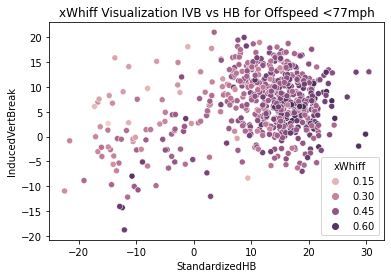

In [171]:
X_test['xWhiff'] = x_whiff_test_OS
sns.scatterplot(x = X_test[(X_test['RelSpeed'] < 77)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] < 77)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] < 77)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed <77mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed 77-80mph')]

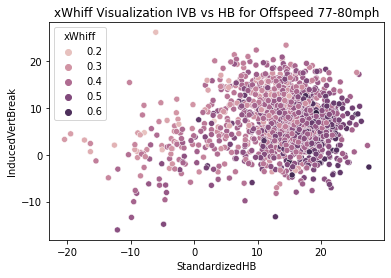

In [172]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 77) & (X_test['RelSpeed'] < 80)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 77) & (X_test['RelSpeed'] < 80)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 77) & (X_test['RelSpeed'] < 80)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed 77-80mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed 80-83mph')]

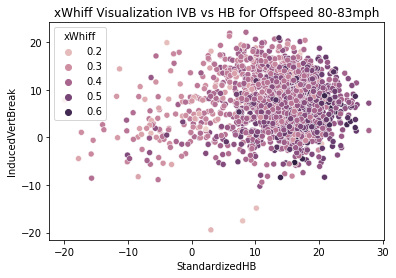

In [173]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 83)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 83)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 83)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed 80-83mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed 83-86mph')]

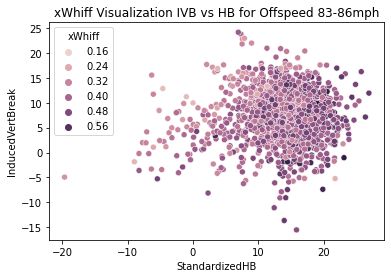

In [174]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 83) & (X_test['RelSpeed'] < 86)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 83) & (X_test['RelSpeed'] < 86)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 83) & (X_test['RelSpeed'] < 86)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed 83-86mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Offspeed >86mph')]

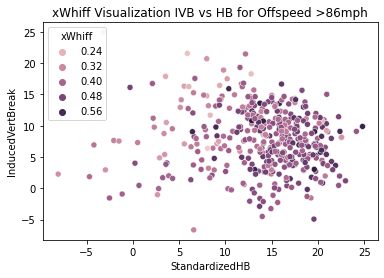

In [175]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 86]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 86]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 86]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Offspeed >86mph')

The interpretation of these scatterplots for the Offspeed section is a bit murkier. It does seem to favor arm side HB and slower pitches, which makes semse, but the addition of the VeloDiff, IVBDiff, and HBDiff features I believe has a big effect. From my knowledge of baseball, those really make a difference when it comes to changeups and splitters. As a pitcher, it is much more important to have a changeup that differs from your fastball rather than it being purely a nasty pitch. Let's see if we can visualize the effect of those three features on the model better.

It is also relevant to note that the outlier pitches away from the main cloud are likely mistagged pitches

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed <3mph Velo Diff')]

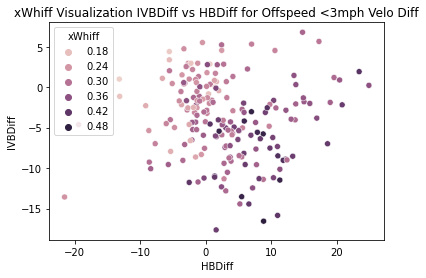

In [177]:
sns.scatterplot(x = X_test[X_test['VeloDiff'] > -3]['HBDiff'], y = X_test[X_test['VeloDiff'] > -3]['IVBDiff'], hue = X_test[X_test['VeloDiff'] > -3]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed <3mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 3-6mph Velo Diff')]

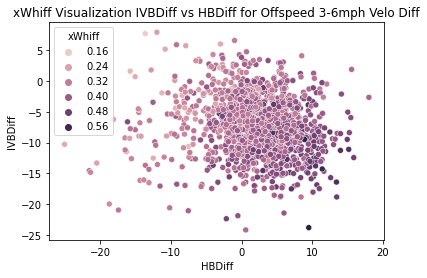

In [178]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 3-6mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 6-9mph Velo Diff')]

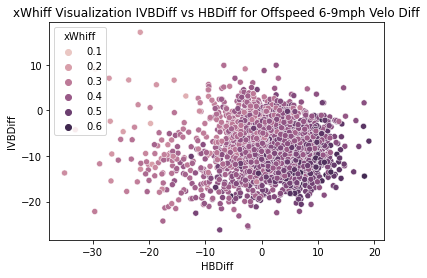

In [179]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 6-9mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 9-12mph Velo Diff')]

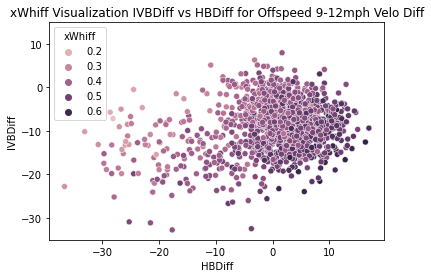

In [180]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 9-12mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed >12mph Velo Diff')]

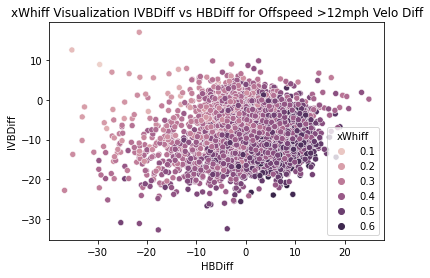

In [181]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] > -12)]['HBDiff'], y = X_test[(X_test['VeloDiff'] > -12)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] > -12)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed >12mph Velo Diff')

These plots show a similar trend to the previous ones, but more clearly. The model favors more arm side movement and less velocity for offspeed pitches

# Model 2: Random Forest

In order to capture more intricacies in the model, I will turn to a Random Forest Classifier. Random Forest is a powerful ML algorithm that uses decision trees and boosting to make classifications and return probabilities, exactly what I need for Stuff+. The tree based model will determine the features most important to the prediction and allow for them to be used multiple times in a tree to capture finer details about the features than logistic regression.

For the initial model, I will start with the default number of trees, 100, and choose the max depth to be 8, in order to visualize the effectiveness of the random forest model before tuning these hyperparameters in a later step.

In [182]:
from sklearn.ensemble import RandomForestClassifier

In [265]:
swings = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'FoulBall') | (all_pitches_FB['PitchCall'] == 'InPlay') | (all_pitches_FB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

init_model_rand_forest_FB = RandomForestClassifier(n_estimators = 100, max_depth=8, max_features = 'sqrt', random_state=0)
init_model_rand_forest_FB.fit(X_train, y_train)
results_rf_FB = init_model_rand_forest_FB.predict_proba(X_train)
results_rf_FB

array([[0.81012876, 0.18987124],
       [0.70636636, 0.29363364],
       [0.76468339, 0.23531661],
       ...,
       [0.80368191, 0.19631809],
       [0.57177132, 0.42822868],
       [0.78071481, 0.21928519]])

In [266]:
x_whiff_rf_FB_train = [x[1] for x in results_rf_FB]
avg_x_whiff_rf_FB_train = np.mean(x_whiff_rf_FB_train)
actual_whiff_pct_train_rf_FB = y_train.mean()
avg_x_whiff_rf_FB_train, actual_whiff_pct_train_rf_FB

(0.27133663113902357, 0.2714356561716729)

In [267]:
results_rf_FB_test = init_model_rand_forest_FB.predict_proba(X_test)
x_whiff_rf_FB_test = [x[1] for x in results_rf_FB_test]

train_log_loss_rf_FB = metrics.log_loss(y_train, x_whiff_rf_FB_train)
test_log_loss_rf_FB = metrics.log_loss(y_test, x_whiff_rf_FB_test)
train_log_loss_rf_FB, test_log_loss_rf_FB

(0.5538468523764246, 0.5640134068195596)

The log loss is slightly lower than Logistic Regression, which is a positive step. I will tune the model further, but for now, let's visualize the results with IVB vs HB again.

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')]

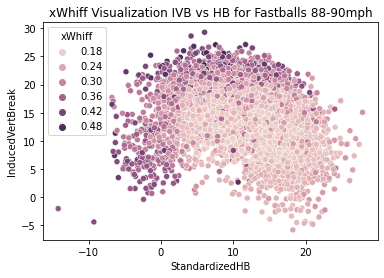

In [206]:
X_test['xWhiff'] = x_whiff_rf_FB_test
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')]

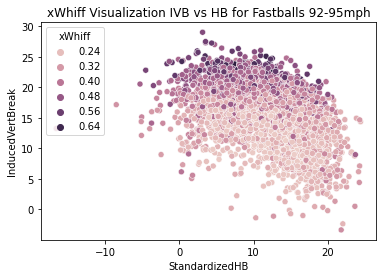

In [199]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')

These look really good! Not only is the log loss lower, but the model seems to be making clearer predictions. There is a clear difference in xWhiff for ride fastballs (more IVB) in both plots and Cutters (HB~0) in the 88-90 plot. The logistic regression model was able to find favorable traits, but it was much more random in its predictions than the random forest. Next, I will tune the model to find the optimal number of trees and tree depth based on log loss.

In [207]:
X_test = X_test.drop(columns = ['xWhiff'])

In [210]:
for n in np.arange(25, 126, 25):
    for d in np.arange(2, 16, 1):
        model_rand_forest_FB = RandomForestClassifier(n_estimators = n, max_depth=d, max_features = 'sqrt', random_state=0)
        model_rand_forest_FB.fit(X_train, y_train)
        results_rf_FB = model_rand_forest_FB.predict_proba(X_train)
        x_whiff_rf_FB_train = [x[1] for x in results_rf_FB]
        results_rf_FB_test = model_rand_forest_FB.predict_proba(X_test)
        x_whiff_rf_FB_test = [x[1] for x in results_rf_FB_test]
        train_log_loss_rf_FB = metrics.log_loss(y_train, x_whiff_rf_FB_train)
        test_log_loss_rf_FB = metrics.log_loss(y_test, x_whiff_rf_FB_test)
        print(str(n) + " Trees, Depth: " + str(d) + " - Train loss: " + str(train_log_loss_rf_FB) + " Test loss: " + str(test_log_loss_rf_FB))

25 Trees, Depth: 2 - Train loss: 0.5724967264261354 Test loss: 0.5749558636922321
25 Trees, Depth: 3 - Train loss: 0.5689815267793809 Test loss: 0.5719249583152174
25 Trees, Depth: 4 - Train loss: 0.5660784150731125 Test loss: 0.569854461646016
25 Trees, Depth: 5 - Train loss: 0.5631510652747376 Test loss: 0.5676351026167551
25 Trees, Depth: 6 - Train loss: 0.5603764491127855 Test loss: 0.5661960633762655
25 Trees, Depth: 7 - Train loss: 0.557376844728406 Test loss: 0.5648652110698776
25 Trees, Depth: 8 - Train loss: 0.5540675123681468 Test loss: 0.564212094012605
25 Trees, Depth: 9 - Train loss: 0.5492524155392899 Test loss: 0.5635157701025296
25 Trees, Depth: 10 - Train loss: 0.5432522899809005 Test loss: 0.563752172294578
25 Trees, Depth: 11 - Train loss: 0.5354567105347353 Test loss: 0.5629137914579184
25 Trees, Depth: 12 - Train loss: 0.5254987034503874 Test loss: 0.5630304878007136
25 Trees, Depth: 13 - Train loss: 0.512479827557085 Test loss: 0.5622177505413347
25 Trees, Depth: 

KeyboardInterrupt: 

Based on the hyperparameter tuning above, I will make my random forest model with 50 trees and depth 11. The number of trees turned out to not matter much, while the depth of the trees did. Around 9-11 depth was where the Test loss flattened out while the Train loss wasn't too low (a sign of overfitting). Also, since the amount of trees doesn't adjust loss much, I will choose the lower amount to make the model simpler and less computationally expensive.

In [268]:
model_rand_forest_FB_v1 = RandomForestClassifier(n_estimators = 50, max_depth=11, max_features = 'sqrt', random_state=0)
model_rand_forest_FB_v1.fit(X_train, y_train)
results_rf_FB = model_rand_forest_FB_v1.predict_proba(X_train)
x_whiff_rf_FB_train = [x[1] for x in results_rf_FB]
results_rf_FB_test = model_rand_forest_FB_v1.predict_proba(X_test)
x_whiff_rf_FB_test = [x[1] for x in results_rf_FB_test]

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')]

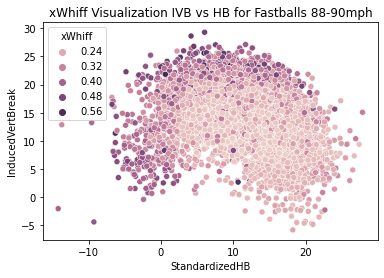

In [272]:
X_test['xWhiff'] = x_whiff_rf_FB_test
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 88) & (X_test['RelSpeed'] < 90)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 88-90mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 90-92mph')]

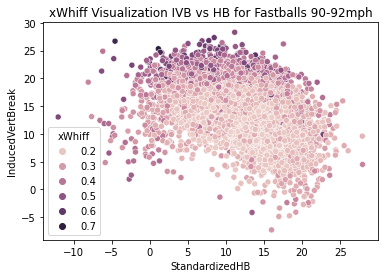

In [213]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 90) & (X_test['RelSpeed'] < 92)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 90-92mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')]

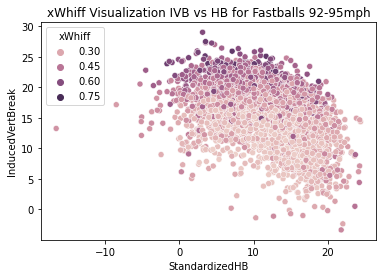

In [214]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 92) & (X_test['RelSpeed'] < 95)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs 92-95mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Fastballs >95mph')]

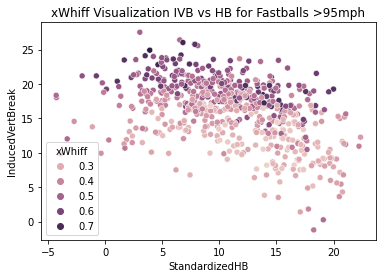

In [215]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 95]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 95]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 95]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Fastballs >95mph')

Looks good! Now I will convert xWhiff to Stuff+ and add it to a table containing each pitcher's average for all the features. Stuff+ is simply xWhiff on a scale where 100 is the average and each additional "point" above or below 100 corresponds to 1% above or below the mean. So a Stuff+ of 125 is xWhiff 25% above average, 80 is 20% below average.

In [273]:
takes = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'BallCalled') | (all_pitches_FB['PitchCall'] == 'StrikeCalled')][['RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()

results_rf_fb_takes = model_rand_forest_FB_v1.predict_proba(takes)
x_whiff_rf_fb_takes = [x[1] for x in results_rf_fb_takes]
takes['xWhiff'] = x_whiff_rf_fb_takes
X_train['xWhiff'] = x_whiff_rf_FB_train

all_xWhiff = pd.concat([takes['xWhiff'], X_train['xWhiff'], X_test['xWhiff']])
all_pitches_FB = all_pitches_FB.merge(all_xWhiff, left_index = True, right_index = True)

all_pitches_FB['Stuff+'] = (all_pitches_FB['xWhiff'] / all_pitches_FB['xWhiff'].mean()) * 100

In [274]:
stuff_plus_leaderboard_FB = all_pitches_FB.groupby(['Pitcher', 'TaggedPitchType'])[['Stuff+', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'AdjustedVAA', 'AdjustedHAA']].mean().sort_values('Stuff+', ascending = False)
stuff_plus_leaderboard_FB['Stuff+'] = stuff_plus_leaderboard_FB['Stuff+'].astype(int)
stuff_plus_leaderboard_FB[:10]

Stuff+   RelSpeed  RelHeight   RelSide  \
Pitcher            TaggedPitchType                                           
Mueller, Matthew   Cutter              238  89.545700   6.468305 -0.474215   
Jameson, Fisher    Cutter              218  84.255974   6.961893  0.686051   
Nelson, Cameron    Sinker              214  92.481590   4.459603 -3.361413   
Smith, Hagen       Sinker              210  95.737313   5.489927 -3.360510   
                   Fastball            207  95.592231   5.596785 -3.190081   
Yesavage, Trey     Cutter              206  85.945289   6.843621  1.143196   
Dean, Tyler        Cutter              203  91.973890   6.132200  1.515820   
Chestnutt, Ben     Sinker              203  73.002990   5.128780  2.833510   
Lyon, Luke         Cutter              197  87.711340   4.858630  1.409530   
Adelmann, Jonathan Sinker              196  81.454320   6.364020  2.509930   

                                    Extension  InducedVertBreak  HorzBreak  \
Pitcher            TaggedPitchType                                           
Mueller, Matthew   Cutter            6.642875         25.395310 -11.759120   
Jameson, Fisher    Cutter            4.836111          3.930955   1.890623   
Nelson, Cameron    Sinker            6.276827         11.618547 -17.214210   
Smith, Hagen       Sinker            6.215532         15.501743 -14.929315   
                   Fastball          6.115964         16.484086 -13.192950   
Yesavage, Trey     Cutter            5.362769          2.981878   2.813450   
Dean, Tyler        Cutter            6.278610         21.342650  -0.597050   
Chestnutt, Ben     Sinker            5.706940         -6.280080 -16.980250   
Lyon, Luke         Cutter            5.680560          8.177290  -6.791180   
Adelmann, Jonathan Sinker            5.803620          3.602210 -15.116620   

                                    AdjustedVAA  AdjustedHAA  
Pitcher            TaggedPitchType                            
Mueller, Matthew   Cutter              1.233000    -2.891590  
Jameson, Fisher    Cutter             -1.439227     1.510327  
Nelson, Cameron    Sinker              1.532482     1.167297  
Smith, Hagen       Sinker              0.938692     1.302759  
                   Fastball            0.702110     1.323986  
Yesavage, Trey     Cutter             -1.341807     0.984285  
Dean, Tyler        Cutter              1.303133     0.363579  
Chestnutt, Ben     Sinker             -2.616133    -3.916157  
Lyon, Luke         Cutter              1.174189    -0.048641  
Adelmann, Jonathan Sinker             -2.090761    -3.568239

In [306]:
all_pitches_FB = all_pitches_FB.drop(columns = ['xWhiff', 'Stuff+'])

After I first found the Stuff+ Leaderboard for the random forest model, I noticed that the model very much favors cutters. Most of the top cutters seemed to be closer to sliders or misreads/mistags. Since breaking balls naturally have a higher whiff rate than fastballs (42% to 27%, see logistic regression models), cutters that act more like sliders will naturally produce more whiff characterstics, and cause an unfair comparison when compared to fastballs. However, lots of pitchers throw cutters as their primary fastball that don't act similarly to sliders. So, for my final model, I came up with an idea: I'll move cutters to breaking ball model for pitchers whose primary FB is not a cutter, keep in FB model for those who it is their primary fastball.

In [355]:
all_pitches_FB = all_pitches[(all_pitches['TaggedPitchType'] == 'Fastball') | (all_pitches['TaggedPitchType'] == 'Sinker') | ((all_pitches['TaggedPitchType'] == 'Cutter') & (all_pitches['primaryFB'] == 'Cutter'))]
all_pitches_BB = all_pitches[(all_pitches['TaggedPitchType'] == 'Curveball') | (all_pitches['TaggedPitchType'] == 'Slider') | ((all_pitches['TaggedPitchType'] == 'Cutter') & (all_pitches['primaryFB'] != 'Cutter'))]
all_pitches_OS = all_pitches[(all_pitches['TaggedPitchType'] == 'ChangeUp') | (all_pitches['TaggedPitchType'] == 'Splitter') | (all_pitches['TaggedPitchType'] == 'Knuckleball')]

all_pitches_BB['VeloDiff'] = all_pitches_BB['RelSpeed'] - all_pitches_BB['RelSpeedFBavg']
all_pitches_BB['IVBDiff'] = all_pitches_BB['InducedVertBreak'] - all_pitches_BB['InducedVertBreakFBavg']
all_pitches_BB['HBDiff'] = all_pitches_BB['StandardizedHB'] - all_pitches_BB['StandardizedHBFBavg']

all_pitches_OS['VeloDiff'] = all_pitches_OS['RelSpeed'] - all_pitches_OS['RelSpeedFBavg']
all_pitches_OS['IVBDiff'] = all_pitches_OS['InducedVertBreak'] - all_pitches_OS['InducedVertBreakFBavg']
all_pitches_OS['HBDiff'] = all_pitches_OS['StandardizedHB'] - all_pitches_OS['StandardizedHBFBavg']

C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\2446149413.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_pitches_BB['VeloDiff'] = all_pitches_BB['RelSpeed'] - all_pitches_BB['RelSpeedFBavg']
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\2446149413.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_pitches_BB['IVBDiff'] = all_pitches_BB['InducedVertBreak'] - all_pitches_BB['InducedVertBreakFBavg']
C:\Users\Matthew Dalquist\AppData\Local\Temp\ipykernel_14648\24461494

# Final Model: Fastballs

In [308]:
swings = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'FoulBall') | (all_pitches_FB['PitchCall'] == 'InPlay') | (all_pitches_FB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

model_rand_forest_FB_v2 = RandomForestClassifier(n_estimators = 50, max_depth=11, max_features = 'sqrt', random_state=0)
model_rand_forest_FB_v2.fit(X_train, y_train)
results_rf_FB = model_rand_forest_FB_v2.predict_proba(X_train)
x_whiff_rf_FB_train = [x[1] for x in results_rf_FB]
results_rf_FB_test = model_rand_forest_FB_v2.predict_proba(X_test)
x_whiff_rf_FB_test = [x[1] for x in results_rf_FB_test]

In [309]:
takes = all_pitches_FB[(all_pitches_FB['PitchCall'] == 'BallCalled') | (all_pitches_FB['PitchCall'] == 'StrikeCalled')][['RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA']].dropna()

results_rf_fb_takes = model_rand_forest_FB_v2.predict_proba(takes)
x_whiff_rf_fb_takes = [x[1] for x in results_rf_fb_takes]
takes['xWhiff'] = x_whiff_rf_fb_takes
X_train['xWhiff'] = x_whiff_rf_FB_train
X_test['xWhiff'] = x_whiff_rf_FB_test

all_xWhiff = pd.concat([takes['xWhiff'], X_train['xWhiff'], X_test['xWhiff']])
all_pitches_FB = all_pitches_FB.merge(all_xWhiff, left_index = True, right_index = True)

all_pitches_FB['Stuff+'] = (all_pitches_FB['xWhiff'] / all_pitches_FB['xWhiff'].mean()) * 100

In [310]:
stuff_plus_leaderboard_FB = all_pitches_FB.groupby(['Pitcher', 'TaggedPitchType'])[['Stuff+', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'AdjustedVAA', 'AdjustedHAA']].mean().sort_values('Stuff+', ascending = False)
stuff_plus_leaderboard_FB['Stuff+'] = stuff_plus_leaderboard_FB['Stuff+'].astype(int)
stuff_plus_leaderboard_FB[:10]

,,Stuff+,RelSpeed,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,AdjustedVAA,AdjustedHAA
Pitcher,TaggedPitchType,,,,,,,,,
"Smith, Hagen",Sinker,216,95.737313,5.489927,-3.360510,6.215532,15.501743,-14.929315,0.938692,1.302759
"Grotyohann, Connor",Sinker,214,93.194410,6.216450,1.839100,6.309180,23.601980,9.118390,0.837285,-0.771898
"Smith, Hagen",Fastball,210,95.592231,5.596785,-3.190081,6.115964,16.484086,-13.192950,0.702110,1.323986
"Conklin, MacCallan",Fastball,200,90.919935,5.404450,2.437735,6.264600,20.493790,6.144375,0.916650,-1.295531
"Pence, Dalton",Fastball,200,92.382857,5.659800,-1.149213,5.929837,21.276110,-9.606552,0.839330,-0.524560
"Wilson, Nick",Sinker,196,94.018850,5.231120,1.484770,6.230170,17.349340,7.080240,1.570763,-0.422924
"Rice, Owen",Fastball,195,92.816413,5.956015,-1.745512,6.226461,21.654290,-9.283793,0.566453,0.192182
"Keisel, Janzen",Fastball,193,94.005043,5.347754,2.831625,5.647604,18.359513,12.209431,0.936461,-1.186648
"Cranton, Hunter",Fastball,191,97.184445,5.623066,1.770279,5.668051,17.574015,8.923829,0.894563,-0.216749


# Final Model: Breaking Balls

In [348]:
swings = all_pitches_BB[(all_pitches_BB['PitchCall'] == 'FoulBall') | (all_pitches_BB['PitchCall'] == 'InPlay') | (all_pitches_BB['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

In [350]:
# Tune hyperparameters
for n in np.arange(50, 126, 25):
    for d in np.arange(7, 12, 1):
        model_rand_forest = RandomForestClassifier(n_estimators = n, max_depth=d, max_features = 'sqrt', random_state=0)
        model_rand_forest.fit(X_train, y_train)
        results_rf = model_rand_forest.predict_proba(X_train)
        x_whiff_rf_train = [x[1] for x in results_rf]
        results_rf_test = model_rand_forest.predict_proba(X_test)
        x_whiff_rf_test = [x[1] for x in results_rf_test]
        train_log_loss_rf = metrics.log_loss(y_train, x_whiff_rf_train)
        test_log_loss_rf = metrics.log_loss(y_test, x_whiff_rf_test)
        print(str(n) + " Trees, Depth: " + str(d) + " - Train loss: " + str(train_log_loss_rf) + " Test loss: " + str(test_log_loss_rf))

50 Trees, Depth: 7 - Train loss: 0.6653147220003417 Test loss: 0.6684533724428735
50 Trees, Depth: 8 - Train loss: 0.6604945366998619 Test loss: 0.6673634391481063
50 Trees, Depth: 9 - Train loss: 0.6547481907761102 Test loss: 0.666660887817736
50 Trees, Depth: 10 - Train loss: 0.6465691167010839 Test loss: 0.6660772632706318
50 Trees, Depth: 11 - Train loss: 0.6368210894955242 Test loss: 0.6656678879797004
75 Trees, Depth: 7 - Train loss: 0.6653163930253084 Test loss: 0.668238608777111
75 Trees, Depth: 8 - Train loss: 0.6606166229654995 Test loss: 0.6674716757555819
75 Trees, Depth: 9 - Train loss: 0.6545136217577443 Test loss: 0.6663404199806661
75 Trees, Depth: 10 - Train loss: 0.646785579067607 Test loss: 0.6658089560050251
75 Trees, Depth: 11 - Train loss: 0.636655783971687 Test loss: 0.6651524992244838
100 Trees, Depth: 7 - Train loss: 0.6653452725530652 Test loss: 0.6681622013862301
100 Trees, Depth: 8 - Train loss: 0.6606481185652139 Test loss: 0.667375087161797
100 Trees, Dept

Again, not much difference across the number of trees or depth. 50 trees and with depth 11 it is.

In [323]:
model_rand_forest_BB = RandomForestClassifier(n_estimators = 50, max_depth=11, max_features = 'sqrt', random_state=0)
model_rand_forest_BB.fit(X_train, y_train)
results_rf_BB = model_rand_forest_BB.predict_proba(X_train)
x_whiff_rf_BB_train = [x[1] for x in results_rf_BB]
results_rf_BB_test = model_rand_forest_BB.predict_proba(X_test)
x_whiff_rf_BB_test = [x[1] for x in results_rf_BB_test]

In [324]:
takes = all_pitches_BB[(all_pitches_BB['PitchCall'] == 'BallCalled') | (all_pitches_BB['PitchCall'] == 'StrikeCalled')][['RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()

results_rf_bb_takes = model_rand_forest_BB.predict_proba(takes)
x_whiff_rf_bb_takes = [x[1] for x in results_rf_bb_takes]
takes['xWhiff'] = x_whiff_rf_bb_takes
X_train['xWhiff'] = x_whiff_rf_BB_train
X_test['xWhiff'] = x_whiff_rf_BB_test

all_xWhiff = pd.concat([takes['xWhiff'], X_train['xWhiff'], X_test['xWhiff']])
all_pitches_BB = all_pitches_BB.merge(all_xWhiff, left_index = True, right_index = True)

all_pitches_BB['Stuff+'] = (all_pitches_BB['xWhiff'] / all_pitches_BB['xWhiff'].mean()) * 100

In [325]:
stuff_plus_leaderboard_BB = all_pitches_BB.groupby(['Pitcher', 'TaggedPitchType'])[['Stuff+', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'AdjustedVAA', 'AdjustedHAA']].mean().sort_values('Stuff+', ascending = False)
stuff_plus_leaderboard_BB['Stuff+'] = stuff_plus_leaderboard_BB['Stuff+'].astype(int)
stuff_plus_leaderboard_BB[:10]

,,Stuff+,RelSpeed,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,AdjustedVAA,AdjustedHAA
Pitcher,TaggedPitchType,,,,,,,,,
"Meyer, Chase",Curveball,152,83.902762,5.476078,1.685106,5.533938,-13.163352,-16.282524,0.648293,-0.871603
"Hults, Connor",Slider,151,79.215960,5.790281,-1.490744,4.649056,-17.851495,11.095234,-1.989739,-0.250087
"Yesavage, Trey",Cutter,151,85.945289,6.843621,1.143196,5.362769,2.981878,2.813450,-1.341807,0.984285
"Burns, Chase",Cutter,150,88.177693,6.516993,2.006302,5.625246,-0.807182,-6.542494,-1.143538,-0.782913
"Mueller, Matthew",Cutter,149,89.545700,6.468305,-0.474215,6.642875,25.395310,-11.759120,1.233000,-2.891590
"Hess, Ben",Curveball,149,76.329442,5.499025,2.258138,5.851037,-16.448854,-16.265804,-0.492324,-1.469331
"Rossi, Tony",Curveball,148,84.476002,5.863153,2.111095,6.092675,-3.523585,-16.809490,1.167668,-1.344521
"Olsen, Bobby",Slider,148,80.162007,5.871437,2.237217,5.473907,-18.813710,-10.561553,-1.930057,-0.789905
"Chrest, Evan",Curveball,148,76.564660,5.628500,1.209160,5.336060,-17.210720,-22.064540,-1.110606,-0.669535


[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls <70mph')]

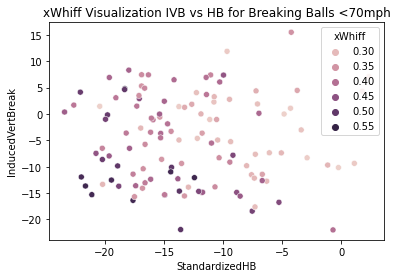

In [328]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] < 70)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] < 70)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] < 70)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls <70mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 70-75mph')]

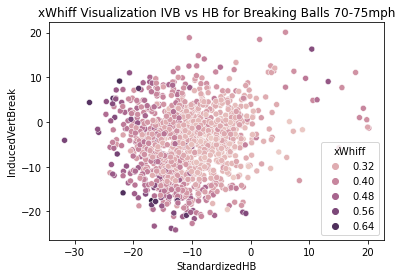

In [329]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 70) & (X_test['RelSpeed'] < 75)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 70-75mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 75-80mph')]

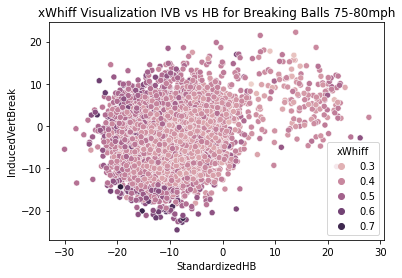

In [330]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 75) & (X_test['RelSpeed'] < 80)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 75-80mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls 80-85mph')]

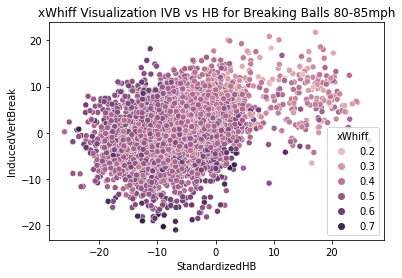

In [331]:
sns.scatterplot(x = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['StandardizedHB'], y = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['InducedVertBreak'], hue = X_test[(X_test['RelSpeed'] > 80) & (X_test['RelSpeed'] < 85)]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls 80-85mph')

[Text(0.5, 1.0, 'xWhiff Visualization IVB vs HB for Breaking Balls >85mph')]

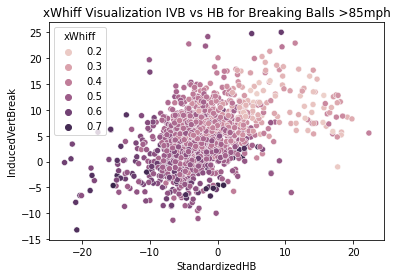

In [332]:
sns.scatterplot(x = X_test[X_test['RelSpeed'] > 85]['StandardizedHB'], y = X_test[X_test['RelSpeed'] > 85]['InducedVertBreak'], hue = X_test[X_test['RelSpeed'] > 85]['xWhiff']).set(title = 'xWhiff Visualization IVB vs HB for Breaking Balls >85mph')

# Final Model: Offspeeds

In [351]:
swings = all_pitches_OS[(all_pitches_OS['PitchCall'] == 'FoulBall') | (all_pitches_OS['PitchCall'] == 'InPlay') | (all_pitches_OS['PitchCall'] == 'StrikeSwinging')][['PitchCall', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()
swings['PitchCall'] = swings['PitchCall'].apply(lambda x: 1 if x == 'StrikeSwinging' else 0)

X_train, X_test, y_train, y_test = train_test_split(swings.drop(columns = 'PitchCall'), swings['PitchCall'], test_size=0.1, random_state=42)

In [352]:
# Tune Hyperparameters
for n in np.arange(50, 126, 25):
    for d in np.arange(7, 12, 1):
        model_rand_forest = RandomForestClassifier(n_estimators = n, max_depth=d, max_features = 'sqrt', random_state=0)
        model_rand_forest.fit(X_train, y_train)
        results_rf = model_rand_forest.predict_proba(X_train)
        x_whiff_rf_train = [x[1] for x in results_rf]
        results_rf_test = model_rand_forest.predict_proba(X_test)
        x_whiff_rf_test = [x[1] for x in results_rf_test]
        train_log_loss_rf = metrics.log_loss(y_train, x_whiff_rf_train)
        test_log_loss_rf = metrics.log_loss(y_test, x_whiff_rf_test)
        print(str(n) + " Trees, Depth: " + str(d) + " - Train loss: " + str(train_log_loss_rf) + " Test loss: " + str(test_log_loss_rf))

50 Trees, Depth: 7 - Train loss: 0.6549510474508438 Test loss: 0.6657624693201604
50 Trees, Depth: 8 - Train loss: 0.6460913404979877 Test loss: 0.6644761276226298
50 Trees, Depth: 9 - Train loss: 0.6350513504628619 Test loss: 0.6637190402326769
50 Trees, Depth: 10 - Train loss: 0.6186925488029941 Test loss: 0.66348227511181
50 Trees, Depth: 11 - Train loss: 0.5996139127498129 Test loss: 0.663448632292774
75 Trees, Depth: 7 - Train loss: 0.6548506762298356 Test loss: 0.6659201682017792
75 Trees, Depth: 8 - Train loss: 0.6460220687953815 Test loss: 0.6641834479150313
75 Trees, Depth: 9 - Train loss: 0.6348972387319577 Test loss: 0.6637408213565364
75 Trees, Depth: 10 - Train loss: 0.619087091622289 Test loss: 0.6633228087438275
75 Trees, Depth: 11 - Train loss: 0.5993605894342786 Test loss: 0.6627715527667136
100 Trees, Depth: 7 - Train loss: 0.6547647051753477 Test loss: 0.6659249689772229
100 Trees, Depth: 8 - Train loss: 0.6458100569290808 Test loss: 0.6644186892237293
100 Trees, Dep

The model seems to overfit to the train data a bit more for the offspeed model than the others with more depth, so I will choose 50 trees with depth 9 for this model.

In [353]:
model_rand_forest_OS = RandomForestClassifier(n_estimators = 50, max_depth=9, max_features = 'sqrt', random_state=0)
model_rand_forest_OS.fit(X_train, y_train)
results_rf_OS = model_rand_forest_OS.predict_proba(X_train)
x_whiff_rf_OS_train = [x[1] for x in results_rf_OS]
results_rf_OS_test = model_rand_forest_OS.predict_proba(X_test)
x_whiff_rf_OS_test = [x[1] for x in results_rf_OS_test]

In [356]:
takes = all_pitches_OS[(all_pitches_OS['PitchCall'] == 'BallCalled') | (all_pitches_OS['PitchCall'] == 'StrikeCalled')][['RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'StandardizedHB', 'AdjustedVAA', 'AdjustedHAA', 'VeloDiff', 'IVBDiff', 'HBDiff']].dropna()

results_rf_OS_takes = model_rand_forest_OS.predict_proba(takes)
x_whiff_rf_OS_takes = [x[1] for x in results_rf_OS_takes]
takes['xWhiff'] = x_whiff_rf_OS_takes
X_train['xWhiff'] = x_whiff_rf_OS_train
X_test['xWhiff'] = x_whiff_rf_OS_test

all_xWhiff = pd.concat([takes['xWhiff'], X_train['xWhiff'], X_test['xWhiff']])
all_pitches_OS = all_pitches_OS.merge(all_xWhiff, left_index = True, right_index = True)

all_pitches_OS['Stuff+'] = (all_pitches_OS['xWhiff'] / all_pitches_OS['xWhiff'].mean()) * 100

In [357]:
stuff_plus_leaderboard_OS = all_pitches_OS.groupby(['Pitcher', 'TaggedPitchType'])[['Stuff+', 'RelSpeed', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak', 'AdjustedVAA', 'AdjustedHAA']].mean().sort_values('Stuff+', ascending = False)
stuff_plus_leaderboard_OS['Stuff+'] = stuff_plus_leaderboard_OS['Stuff+'].astype(int)
stuff_plus_leaderboard_OS[:10]

Stuff+   RelSpeed  RelHeight   RelSide  \
Pitcher          TaggedPitchType                                           
Sweeney, Justin  ChangeUp            161  82.513230   4.879680  1.595330   
Yesavage, Trey   Splitter            148  82.880559   7.021253  1.010888   
                 ChangeUp            146  84.261768   6.992139  0.981939   
Causey, AJ       ChangeUp            144  79.437251   4.126382  1.266410   
Causey, A.J.     ChangeUp            144  78.272361   4.194374  1.006236   
Zabel, Peyton    ChangeUp            143  84.177880   6.876850  0.704340   
Klein, Shugy     ChangeUp            142  83.176610   5.179870 -2.181720   
Straniero, Nolan ChangeUp            141  82.165060   6.229180  1.092170   
Leaman, Cole     ChangeUp            140  80.595760   5.607690  2.395320   
Benford, Tysen   ChangeUp            137  79.898470   6.149730  1.627900   

                                  Extension  InducedVertBreak  HorzBreak  \
Pitcher          TaggedPitchType                                           
Sweeney, Justin  ChangeUp          5.647520         -7.233110  15.700990   
Yesavage, Trey   Splitter          5.038918          5.636264  11.436817   
                 ChangeUp          5.361589          4.546784   8.325860   
Causey, AJ       ChangeUp          4.985620         -3.157570  21.287100   
Causey, A.J.     ChangeUp          4.833372         -1.212109  23.102207   
Zabel, Peyton    ChangeUp          6.256320         -5.938820   0.618780   
Klein, Shugy     ChangeUp          6.361530         -6.624140  -6.517370   
Straniero, Nolan ChangeUp          5.264380         -3.836660  12.070360   
Leaman, Cole     ChangeUp          5.866280        -16.348710 -11.814220   
Benford, Tysen   ChangeUp          6.635650          3.797170  21.594340   

                                  AdjustedVAA  AdjustedHAA  
Pitcher          TaggedPitchType                            
Sweeney, Justin  ChangeUp           -0.322176     0.763168  
Yesavage, Trey   Splitter           -0.896407     0.891773  
                 ChangeUp           -1.354202     0.404869  
Causey, AJ       ChangeUp            0.436938     1.273748  
Causey, A.J.     ChangeUp            0.361730     1.738981  
Zabel, Peyton    ChangeUp           -2.534493     0.405338  
Klein, Shugy     ChangeUp           -0.957395     0.642054  
Straniero, Nolan ChangeUp           -1.338445     0.769610  
Leaman, Cole     ChangeUp           -2.331198    -2.718156  
Benford, Tysen   ChangeUp           -1.415503     1.143298

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed <3mph Velo Diff')]

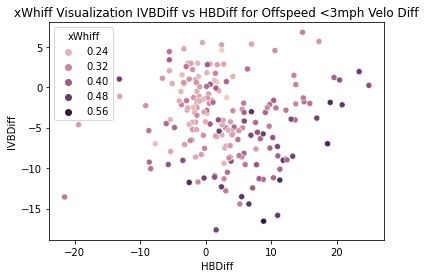

In [358]:
sns.scatterplot(x = X_test[X_test['VeloDiff'] > -3]['HBDiff'], y = X_test[X_test['VeloDiff'] > -3]['IVBDiff'], hue = X_test[X_test['VeloDiff'] > -3]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed <3mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 3-6mph Velo Diff')]

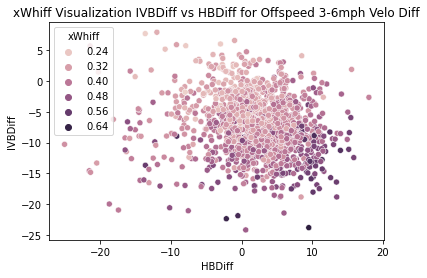

In [359]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -3) & (X_test['VeloDiff'] > -6)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 3-6mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 6-9mph Velo Diff')]

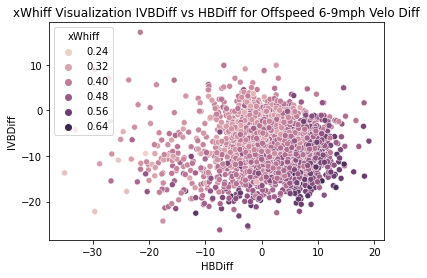

In [360]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -6) & (X_test['VeloDiff'] > -9)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 6-9mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 9-12mph Velo Diff')]

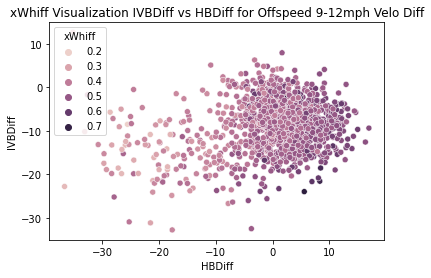

In [361]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['HBDiff'], y = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] < -9) & (X_test['VeloDiff'] > -12)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed 9-12mph Velo Diff')

[Text(0.5, 1.0, 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed >12mph Velo Diff')]

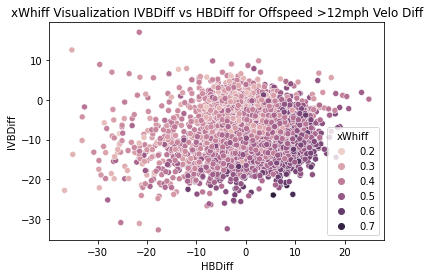

In [362]:
sns.scatterplot(x = X_test[(X_test['VeloDiff'] > -12)]['HBDiff'], y = X_test[(X_test['VeloDiff'] > -12)]['IVBDiff'], hue = X_test[(X_test['VeloDiff'] > -12)]['xWhiff']).set(title = 'xWhiff Visualization IVBDiff vs HBDiff for Offspeed >12mph Velo Diff')

All my pitches for fun

In [365]:
pd.concat([stuff_plus_leaderboard_FB.loc['Dalquist, Matthew'], stuff_plus_leaderboard_BB.loc['Dalquist, Matthew'], stuff_plus_leaderboard_OS.loc['Dalquist, Matthew']])

,Stuff+,RelSpeed,RelHeight,RelSide,Extension,InducedVertBreak,HorzBreak,AdjustedVAA,AdjustedHAA
TaggedPitchType,,,,,,,,,
Fastball,117,89.514442,5.561379,1.005766,5.734971,20.162068,11.471069,0.608831,0.843479
Slider,103,82.391703,5.389155,1.095033,5.430541,2.317986,-4.275145,0.673609,1.051403
Curveball,85,74.355630,5.510690,0.985665,5.101287,-10.968255,-12.889769,-0.248059,0.175581
ChangeUp,101,83.452708,5.223672,1.376832,5.483961,8.851040,17.600799,0.718796,0.804858
